In [137]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
df_train = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')        
df_test = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv')
pd.set_option('display.max_rows', 100)
df_train
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv


,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58640,58640,34,120000,MORTGAGE,5.0,EDUCATION,D,25000,15.95,0.21,Y,10,0
58641,58641,28,28800,RENT,0.0,MEDICAL,C,10000,12.73,0.35,N,8,1
58642,58642,23,44000,RENT,7.0,EDUCATION,D,6800,16.00,0.15,N,2,1
58643,58643,22,30000,RENT,2.0,EDUCATION,A,5000,8.90,0.17,N,3,0


In [138]:
df_test.loc[df_test['person_emp_length']>40]

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
136,58781,51,70000,MORTGAGE,42.0,PERSONAL,A,5400,8.0,0.08,N,23


# Version Summary!


BASELINE MODEL SCORE = 0.86609 (LGBM_Baseline_Model) 
* Now, step by step to increace model score! 
1. Check for NULL Values - and how to fill them
1. Check for outliers - Use 1,5 interquartile rule and check it it is applicable
1. Ratios and other derivate variables to use??
1. Use the LGBM model but defining what are the categorical / numerical variables and how to encode them (OHE, OE)
1. Hyperparameter tuning with Optuna
1. Blend the current model with other models to maximize score??

# (1) Check for Null values

In [139]:
## CHECK FOR NULL VALUES: WE HAVE NO NULL VALUES!
for i in df_train.columns:
    print(i, ' has ', df_train[i].isnull().sum())

id  has  0
person_age  has  0
person_income  has  0
person_home_ownership  has  0
person_emp_length  has  0
loan_intent  has  0
loan_grade  has  0
loan_amnt  has  0
loan_int_rate  has  0
loan_percent_income  has  0
cb_person_default_on_file  has  0
cb_person_cred_hist_length  has  0
loan_status  has  0


In [140]:
df_train.columns

Index(['id', 'person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'loan_status'],
      dtype='object')

# (2) Check for Outliers

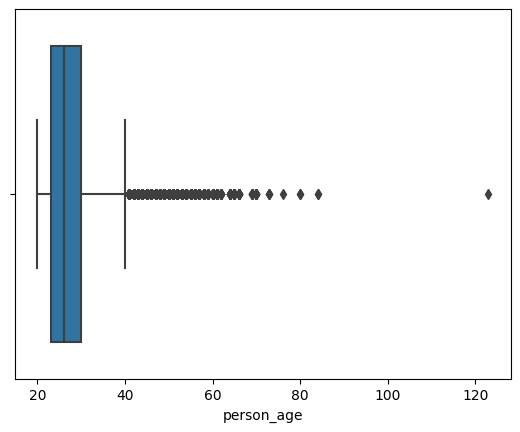

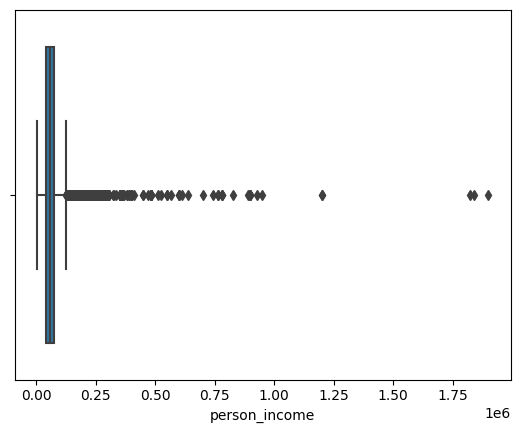

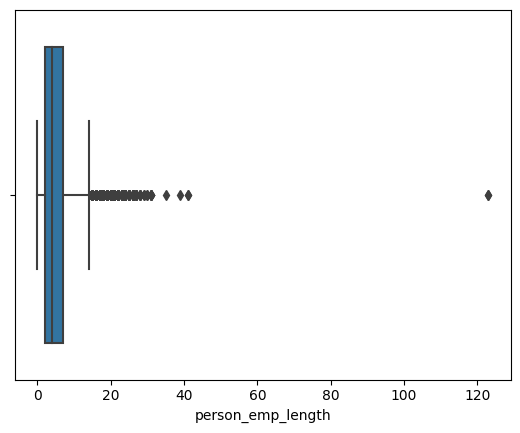

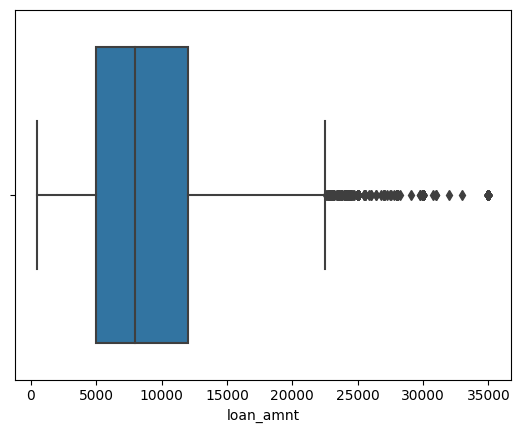

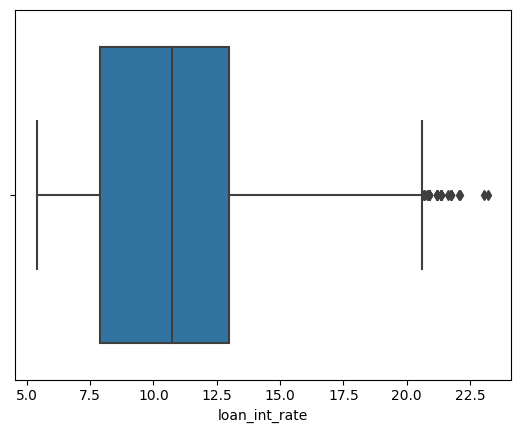

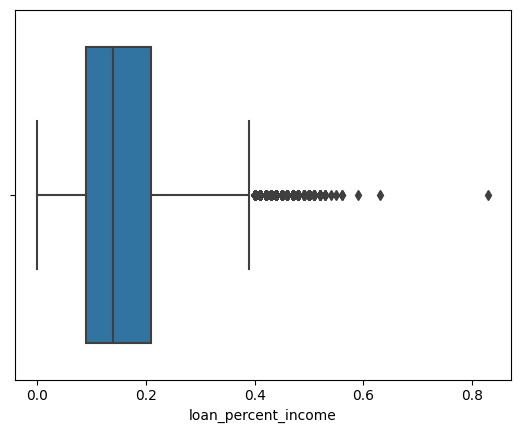

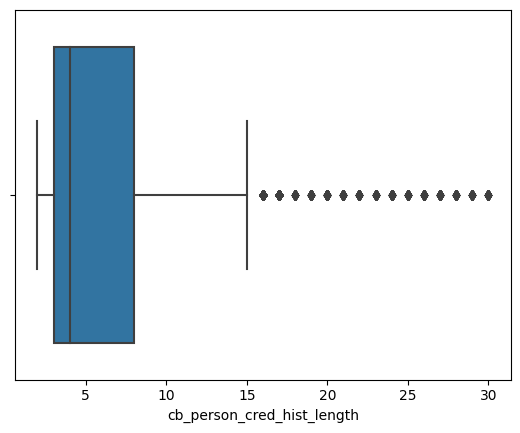

In [141]:
check_list = ['person_age','person_income','person_emp_length','loan_amnt','loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']

for counter, column in enumerate(check_list):
    sns.boxplot(data=df_train, x=column)
    plt.show()


# (2.1) Investigate odd variables one by one

WHAT LOOKS ODD: 
* person_age greater than 120
* person_income outliers
* person_emp_length outliers,
* loan_amnt and loan_int_rate, looks ok
* loan_percent_income greater than 0.8 
* cb_person_cred_hist_length looks ok
* df_train.loc[(df_train['person_age']<lower_bound) |(df_train['person_age']>upper_bound)]

In [142]:
# person_age
df_train.loc[df_train['person_age']>90] ## Looks Odd, drop this line
df_train = df_train.loc[df_train['person_age']<90]


In [143]:
# person_income
df_train.loc[df_train['person_income']> 400000] # why would someone with this income go for a loan? seems to not being conceded. Drop outliers
df_train = df_train.loc[df_train['person_income']<400000]


In [144]:
# person_emp_length
df_train.loc[df_train['person_emp_length']>30] # does not seem an error. seems like an error if it is 123. Set it to 41
df_train.loc[df_train['person_emp_length']>100, 'person_emp_length'] = 40


In [145]:
df_train.loc[df_train['loan_percent_income']>0.8] # Odd number. but loan was given. dont change anything

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
49179,49179,39,12000,RENT,0.0,PERSONAL,C,16000,10.78,0.83,N,12,1


# (3) Adding new variables for analysis!

In [146]:
## Test few new features and if it makes the standard model more accurate
df_train['loan_income_ratio'] = df_train['loan_amnt'] / df_train['person_income']
#df_train['loan_length_ratio'] = df_train['loan_amnt'] / df_train['person_emp_length']
df_train['loan_cost'] = df_train['loan_int_rate'] * df_train['loan_amnt']
df_train['income_to_int_ratio'] = df_train['person_income'] / df_train['loan_int_rate']
df_train['loan_to_length_ratio'] = df_train['loan_amnt'] / df_train['cb_person_cred_hist_length']
df_train['age_hist_ratio'] = df_train['person_age'] / df_train['cb_person_cred_hist_length']
df_train['lenght_to_age'] = df_train['person_emp_length'] / df_train['person_age']
df_train['loan_income_ratio'] = df_train['loan_percent_income'] * df_train['loan_amnt']
# df_train['loan_income_ratio'] = df_train['loan_amnt'] / df_train['loan_grade']



df_test['loan_income_ratio'] = df_test['loan_amnt'] / df_test['person_income']
#df_test['loan_length_ratio'] = df_test['loan_amnt'] / df_test['person_emp_length']
df_test['loan_cost'] = df_test['loan_int_rate'] * df_test['loan_amnt']
df_test['income_to_int_ratio'] = df_test['person_income'] / df_test['loan_int_rate']
df_test['loan_to_length_ratio'] = df_test['loan_amnt'] / df_test['cb_person_cred_hist_length']
df_test['age_hist_ratio'] = df_test['person_age'] / df_test['cb_person_cred_hist_length']
df_test['lenght_to_age'] = df_test['person_emp_length'] / df_test['person_age']
df_test['loan_income_ratio'] = df_test['loan_percent_income'] * df_test['loan_amnt']

#new_features = ['loan_income_ratio', 'loan_length_ratio', 'loan_cost', 'income_to_int_ratio', 'loan_to_length_ratio', 'age_hist_ratio', 'lenght_to_age', 'loan_income_ratio']


In [147]:
###
# Person Home Ownership
df_train.loc[df_train['person_home_ownership'] == 'OTHER', 'person_home_ownership'] = 1
df_train.loc[df_train['person_home_ownership'] == 'RENT', 'person_home_ownership'] = 2
df_train.loc[df_train['person_home_ownership'] == 'MORTGAGE', 'person_home_ownership'] = 3
df_train.loc[df_train['person_home_ownership'] == 'OWN', 'person_home_ownership'] = 4
df_train['person_home_ownership'] = df_train['person_home_ownership'].astype(int)

df_test.loc[df_test['person_home_ownership'] == 'OTHER', 'person_home_ownership'] = 1
df_test.loc[df_test['person_home_ownership'] == 'RENT', 'person_home_ownership'] = 2
df_test.loc[df_test['person_home_ownership'] == 'MORTGAGE', 'person_home_ownership'] = 3
df_test.loc[df_test['person_home_ownership'] == 'OWN', 'person_home_ownership'] = 4
df_test['person_home_ownership'] = df_test['person_home_ownership'].astype(int)


# Loan Intent
df_train.loc[df_train['loan_intent'] == 'EDUCATION', 'loan_intent'] = 1
df_train.loc[df_train['loan_intent'] == 'MEDICAL', 'loan_intent'] = 2
df_train.loc[df_train['loan_intent'] == 'PERSONAL', 'loan_intent'] = 3
df_train.loc[df_train['loan_intent'] == 'VENTURE', 'loan_intent'] = 4
df_train.loc[df_train['loan_intent'] == 'DEBTCONSOLIDATION', 'loan_intent'] = 5
df_train.loc[df_train['loan_intent'] == 'HOMEIMPROVEMENT', 'loan_intent'] = 6
df_train['loan_intent'] = df_train['loan_intent'].astype(int)

df_test.loc[df_test['loan_intent'] == 'EDUCATION', 'loan_intent'] = 1
df_test.loc[df_test['loan_intent'] == 'MEDICAL', 'loan_intent'] = 2
df_test.loc[df_test['loan_intent'] == 'PERSONAL', 'loan_intent'] = 3
df_test.loc[df_test['loan_intent'] == 'VENTURE', 'loan_intent'] = 4
df_test.loc[df_test['loan_intent'] == 'DEBTCONSOLIDATION', 'loan_intent'] = 5
df_test.loc[df_test['loan_intent'] == 'HOMEIMPROVEMENT', 'loan_intent'] = 6
df_test['loan_intent'] = df_test['loan_intent'].astype(int)

# Loan Grade
df_train.loc[df_train['loan_grade'] == 'A', 'loan_grade'] = 7
df_train.loc[df_train['loan_grade'] == 'B', 'loan_grade'] = 6
df_train.loc[df_train['loan_grade'] == 'C', 'loan_grade'] = 5
df_train.loc[df_train['loan_grade'] == 'D', 'loan_grade'] = 4
df_train.loc[df_train['loan_grade'] == 'E', 'loan_grade'] = 3
df_train.loc[df_train['loan_grade'] == 'F', 'loan_grade'] = 2
df_train.loc[df_train['loan_grade'] == 'G', 'loan_grade'] = 1
df_train['loan_grade'] = df_train['loan_grade'].astype(int)

df_test.loc[df_test['loan_grade'] == 'A', 'loan_grade'] = 7
df_test.loc[df_test['loan_grade'] == 'B', 'loan_grade'] = 6
df_test.loc[df_test['loan_grade'] == 'C', 'loan_grade'] = 5
df_test.loc[df_test['loan_grade'] == 'D', 'loan_grade'] = 4
df_test.loc[df_test['loan_grade'] == 'E', 'loan_grade'] = 3
df_test.loc[df_test['loan_grade'] == 'F', 'loan_grade'] = 2
df_test.loc[df_test['loan_grade'] == 'G', 'loan_grade'] = 1
df_test['loan_grade'] = df_test['loan_grade'].astype(int)


# Default on File
df_train.loc[df_train['cb_person_default_on_file'] == 'N', 'cb_person_default_on_file'] = False
df_train.loc[df_train['cb_person_default_on_file'] == 'Y', 'cb_person_default_on_file'] = True
df_train['cb_person_default_on_file'] = df_train['cb_person_default_on_file'].astype(bool)

df_test.loc[df_test['cb_person_default_on_file'] == 'N', 'cb_person_default_on_file'] = False
df_test.loc[df_test['cb_person_default_on_file'] == 'Y', 'cb_person_default_on_file'] = True
df_test['cb_person_default_on_file'] = df_test['cb_person_default_on_file'].astype(bool)

df_train.drop(columns='id', inplace = True)
df_test.drop(columns='id', inplace = True)

df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58600 entries, 0 to 58644
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58600 non-null  int64  
 1   person_income               58600 non-null  int64  
 2   person_home_ownership       58600 non-null  int64  
 3   person_emp_length           58600 non-null  float64
 4   loan_intent                 58600 non-null  int64  
 5   loan_grade                  58600 non-null  int64  
 6   loan_amnt                   58600 non-null  int64  
 7   loan_int_rate               58600 non-null  float64
 8   loan_percent_income         58600 non-null  float64
 9   cb_person_default_on_file   58600 non-null  bool   
 10  cb_person_cred_hist_length  58600 non-null  int64  
 11  loan_status                 58600 non-null  int64  
 12  loan_income_ratio           58600 non-null  float64
 13  loan_cost                   58600 no

In [148]:
df_train.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'loan_status', 'loan_income_ratio',
       'loan_cost', 'income_to_int_ratio', 'loan_to_length_ratio',
       'age_hist_ratio', 'lenght_to_age'],
      dtype='object')

In [149]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
import lightgbm as lgb

























ordinal_columns  = ['loan_grade' ]
one_hot_columns = ['loan_intent', 'person_home_ownership']
numeric_columns = ['person_age', 'person_income', 
       'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'loan_income_ratio'
       , 'loan_cost', 'income_to_int_ratio',
       'loan_to_length_ratio', 'age_hist_ratio', 'lenght_to_age']



X = df_train
X = X.drop(columns='loan_status')
y = df_train.loan_status

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

ordinal_transformer = OrdinalEncoder()
one_hot_transformer = OneHotEncoder(handle_unknown='ignore')
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Normaliza os dados numéricos
])


preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('ord', ordinal_transformer, ordinal_columns),
    ('onehot', one_hot_transformer, one_hot_columns)
])


# Pipeline final com o modelo LGBM
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', lgb.LGBMClassifier())  # Ou LGBMRegressor() para regressão
])

# Treinamento do modelo
model_pipeline.fit(X_train, y_train)

y_pred = model_pipeline.predict(X_valid)
score = roc_auc_score(y_valid, y_pred)
print(score)

[LightGBM] [Info] Number of positive: 6652, number of negative: 40228
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 46880, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.141894 -> initscore=-1.799646
[LightGBM] [Info] Start training from score -1.799646
0.860260841931026


In [150]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39098 entries, 0 to 39097
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  39098 non-null  int64  
 1   person_income               39098 non-null  int64  
 2   person_home_ownership       39098 non-null  int64  
 3   person_emp_length           39098 non-null  float64
 4   loan_intent                 39098 non-null  int64  
 5   loan_grade                  39098 non-null  int64  
 6   loan_amnt                   39098 non-null  int64  
 7   loan_int_rate               39098 non-null  float64
 8   loan_percent_income         39098 non-null  float64
 9   cb_person_default_on_file   39098 non-null  bool   
 10  cb_person_cred_hist_length  39098 non-null  int64  
 11  loan_income_ratio           39098 non-null  float64
 12  loan_cost                   39098 non-null  float64
 13  income_to_int_ratio         390

In [151]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58600 entries, 0 to 58644
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58600 non-null  int64  
 1   person_income               58600 non-null  int64  
 2   person_home_ownership       58600 non-null  int64  
 3   person_emp_length           58600 non-null  float64
 4   loan_intent                 58600 non-null  int64  
 5   loan_grade                  58600 non-null  int64  
 6   loan_amnt                   58600 non-null  int64  
 7   loan_int_rate               58600 non-null  float64
 8   loan_percent_income         58600 non-null  float64
 9   cb_person_default_on_file   58600 non-null  bool   
 10  cb_person_cred_hist_length  58600 non-null  int64  
 11  loan_status                 58600 non-null  int64  
 12  loan_income_ratio           58600 non-null  float64
 13  loan_cost                   58600 no

In [152]:
y_pred = model_pipeline.predict(df_test)
submission = pd.DataFrame()
temp = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv')
submission['id'] = temp['id']
submission['loan_status'] = y_pred
submission.to_csv('/kaggle/working/outp.csv', index=False)
